In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd as xd
import openpyxl
import datetime as dt
import seaborn as sns
import requests
import math
import warnings
from scipy import interpolate

warnings.filterwarnings('ignore')

# Data Prep

## House Prices

In [2]:
#Prior to 2005 https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/6416.0.55.001Mar%202006?OpenDocument
#ABS data https://www.abs.gov.au/statistics/economy/price-indexes-and-inflation/residential-property-price-indexes-eight-capital-cities/latest-release#data-downloads
#Domain data https://www.domain.com.au/research/house-price-report #could webscrape but not worth the time
#Put it together in excel

In [3]:
df = pd.read_csv('data/HousePrices.csv', parse_dates=['Date'])
df = df.set_index(df['Date'])
df = df.drop('Date', axis = 1)

In [4]:
df = df*1000

In [5]:
len(df.index)

87

In [6]:
df

,Sydney,Melbourne,Brisbane,Adelaide,Perth,Hobart,Darwin,Canberra
Date,,,,,,,,
2002-01-03,365000.0,241000.0,185000.0,166000.0,190000.0,123300.0,190000.0,245000.0
2002-01-06,393500.0,260000.0,182600.0,175000.0,190000.0,117000.0,188300.0,258000.0
2002-01-09,413000.0,265000.0,198000.0,181000.0,195000.0,124000.0,190000.0,275000.0
2002-01-12,444000.0,280000.0,208000.0,195000.0,206000.0,128000.0,195000.0,291000.0
2003-01-03,434500.0,270000.0,225000.0,209400.0,216000.0,145000.0,198000.0,300000.0
...,...,...,...,...,...,...,...,...
2022-01-09,1464370.0,1028450.0,811310.0,795090.0,645950.0,741280.0,623820.0,1096110.0
2022-01-12,1441550.0,1028130.0,806800.0,792470.0,664320.0,709800.0,643880.0,1073960.0
2023-01-03,1459860.0,1023760.0,805820.0,795360.0,672180.0,689130.0,623600.0,1047110.0


## Interest Rates

In [7]:
#RBA webscrape rates
URL = "https://www.rba.gov.au/statistics/cash-rate/"
page = requests.get(URL)

table_MN = pd.read_html(URL, match='Interest Rate Decisions')

RBA = table_MN[0]
RBA = RBA.iloc[::-1]
RBA = RBA.iloc[142:] #change starting time to match to March 2002
RBA['Effective Date'] = pd.to_datetime(RBA['Effective Date'])
RBA = RBA.set_index('Effective Date')
RBA['Cash rate target'] = RBA['Cash rate target %'].astype(float)/100

In [8]:
RBA

,Change% points,Cash rate target %,Related Documents,Cash rate target
Effective Date,,,,
2002-03-06,0.00,4.25,NaN,0.0425
2002-04-03,0.00,4.25,NaN,0.0425
2002-05-08,+0.25,4.50,Statement,0.0450
2002-06-05,+0.25,4.75,Statement,0.0475
2002-07-03,0.00,4.75,NaN,0.0475
...,...,...,...,...
2023-07-05,0.00,4.10,Statement Minutes,0.0410
2023-08-02,0.00,4.10,Statement Minutes,0.0410
2023-09-06,0.00,4.10,Statement Minutes,0.0410


In [9]:
row = 0
rates = np.array([])
while row < len(RBA.index):
    #if RBA month = 3, 6, 9 or 12 then transfer cash rate to df
    if RBA.index[row].month == 3 or RBA.index[row].month == 6 or RBA.index[row].month == 9 or RBA.index[row].month == 12:
        #print(RBA.index[row])
        if(RBA.index[row-1].month != RBA.index[row].month): #to fix when they change rates twice in one month
        #rates.append(RBA['Cash rate target'][row])
            rates = np.append(rates, RBA['Cash rate target'][row])
    row += 1

In [10]:
len(rates)

87

In [11]:
rates = rates.round(4)

In [12]:
df['RBA Rate'] = rates

In [13]:
df['Mortgage Rate'] = df['RBA Rate'].astype(float) + 0.02 #assumption...

In [14]:
df

,Sydney,Melbourne,Brisbane,Adelaide,Perth,Hobart,Darwin,Canberra,RBA Rate,Mortgage Rate
Date,,,,,,,,,,
2002-01-03,365000.0,241000.0,185000.0,166000.0,190000.0,123300.0,190000.0,245000.0,0.0425,0.0625
2002-01-06,393500.0,260000.0,182600.0,175000.0,190000.0,117000.0,188300.0,258000.0,0.0475,0.0675
2002-01-09,413000.0,265000.0,198000.0,181000.0,195000.0,124000.0,190000.0,275000.0,0.0475,0.0675
2002-01-12,444000.0,280000.0,208000.0,195000.0,206000.0,128000.0,195000.0,291000.0,0.0475,0.0675
2003-01-03,434500.0,270000.0,225000.0,209400.0,216000.0,145000.0,198000.0,300000.0,0.0475,0.0675
...,...,...,...,...,...,...,...,...,...,...
2022-01-09,1464370.0,1028450.0,811310.0,795090.0,645950.0,741280.0,623820.0,1096110.0,0.0235,0.0435
2022-01-12,1441550.0,1028130.0,806800.0,792470.0,664320.0,709800.0,643880.0,1073960.0,0.0310,0.0510
2023-01-03,1459860.0,1023760.0,805820.0,795360.0,672180.0,689130.0,623600.0,1047110.0,0.0360,0.0560


## Median Income

In [15]:
#https://www.abs.gov.au/statistics/labour/earnings-and-working-conditions/employee-earnings/latest-release#data-downloads
#Table 1 - Employee earnings, 1975-2022 -> Not capital cities... But it's the best we have got.
#Again because ABS excel files are strangely formatted I did some edits on Excel 
#Also added this years income same as last years... Bad but whatever...

In [16]:
MI = pd.read_csv('data/MedianIncomes.csv', parse_dates=['Date'])
MI = MI.set_index(MI['Date'])
MI = MI.drop('Date', axis = 1)

In [17]:
year = 0
quarter = 0
total = 0
colindex = 0
cols = ['NSWMI', 'VICMI', 'QLDMI', 'SAMI', 'WAMI', 'TASMI', 'NTMI', 'ACTMI']
for col in cols:
    df[col] = 0
for col in cols:
    while year < len(MI.index):
        while quarter < 4 and total < 87:
            df[col][total] = MI.iloc[year][colindex]*52
            #print(df['NSWMI'][quarter])
            quarter += 1
            total += 1
            #print("qters ", quarters)
            #print("year ", year)
        quarter = 0
        year += 1
    colindex +=1
    total = 0
    year = 0

In [18]:
df

,Sydney,Melbourne,Brisbane,Adelaide,Perth,Hobart,Darwin,Canberra,RBA Rate,Mortgage Rate,NSWMI,VICMI,QLDMI,SAMI,WAMI,TASMI,NTMI,ACTMI
Date,,,,,,,,,,,,,,,,,,
2002-01-03,365000.0,241000.0,185000.0,166000.0,190000.0,123300.0,190000.0,245000.0,0.0425,0.0625,33800.0,31409.04,31200.00,31200.00,31980.0,28600.0,36400.0,39000.00
2002-01-06,393500.0,260000.0,182600.0,175000.0,190000.0,117000.0,188300.0,258000.0,0.0475,0.0675,33800.0,31409.04,31200.00,31200.00,31980.0,28600.0,36400.0,39000.00
2002-01-09,413000.0,265000.0,198000.0,181000.0,195000.0,124000.0,190000.0,275000.0,0.0475,0.0675,33800.0,31409.04,31200.00,31200.00,31980.0,28600.0,36400.0,39000.00
2002-01-12,444000.0,280000.0,208000.0,195000.0,206000.0,128000.0,195000.0,291000.0,0.0475,0.0675,33800.0,31409.04,31200.00,31200.00,31980.0,28600.0,36400.0,39000.00
2003-01-03,434500.0,270000.0,225000.0,209400.0,216000.0,145000.0,198000.0,300000.0,0.0475,0.0675,34840.0,32441.24,31200.00,31694.52,32240.0,31200.0,35955.4,40524.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-09,1464370.0,1028450.0,811310.0,795090.0,645950.0,741280.0,623820.0,1096110.0,0.0235,0.0435,65000.0,65000.00,62965.24,58513.52,68380.0,55923.4,72800.0,78933.92
2022-01-12,1441550.0,1028130.0,806800.0,792470.0,664320.0,709800.0,643880.0,1073960.0,0.0310,0.0510,65000.0,65000.00,62965.24,58513.52,68380.0,55923.4,72800.0,78933.92
2023-01-03,1459860.0,1023760.0,805820.0,795360.0,672180.0,689130.0,623600.0,1047110.0,0.0360,0.0560,65000.0,65000.00,62965.24,58513.52,68380.0,55923.4,72800.0,78933.92


# Calculating Years to Pay Mortgage 

$\huge
n = \frac {log(\frac{1}{-(\frac{PV \times i}{CF}-1)})}{log(1+i)}
$
##### where n = years, PV = present value, i = mortgage rate, CF = median yearly income

## If rates stayed constant

In [156]:
MI = ['NSWMI', 'VICMI', 'QLDMI', 'SAMI', 'WAMI', 'TASMI', 'NTMI', 'ACTMI']
MY = ['Sydney Years', 'Melbourne Years', 'Brisbane Years', 'Adelaide Years', 'Perth Years', 'Hobart Years', 'Darwin Years', 'Canberra Years']

for city in MY:
    df[city] = 0

row = 0
cityindex = 0
#iterate through columns
for city in MY:
    #iterate through rows
    for i in df.index:
        try:
            print(city)
            df[city][row] = math.log(1/-((df.iloc[row][cityindex]*df['Mortgage Rate'][row]/df.iloc[row][cityindex+10])-1)) / math.log(1+df['Mortgage Rate'][row])
        except ValueError as e:
            df[city][row] = np.nan
        print(df[city][row])
        row += 1
    row = 0
    cityindex += 1

Sydney Years
18.535415245642838
Sydney Years
23.59192985571747
Sydney Years
26.664365906195798
Sydney Years
33.33762702950582
Sydney Years
28.230094393125388
Sydney Years
33.96231268627749
Sydney Years
40.70406986745045
Sydney Years
nan
Sydney Years
nan
Sydney Years
nan
Sydney Years
nan
Sydney Years
nan
Sydney Years
nan
Sydney Years
nan
Sydney Years
nan
Sydney Years
nan
Sydney Years
32.38086813640339
Sydney Years
55.112103243981316
Sydney Years
58.270290162359366
Sydney Years
nan
Sydney Years
47.224096618312224
Sydney Years
nan
Sydney Years
nan
Sydney Years
nan
Sydney Years
nan
Sydney Years
nan
Sydney Years
nan
Sydney Years
18.888898107609577
Sydney Years
14.956587529832372
Sydney Years
16.69168716289901
Sydney Years
17.224674931840486
Sydney Years
26.915743941900345
Sydney Years
23.616200049910173
Sydney Years
30.198752354392674
Sydney Years
28.1895328118059
Sydney Years
34.39243704462946
Sydney Years
27.067051955913303
Sydney Years
29.44138379418565
Sydney Years
26.065537101425885
Sy

## Accounting for rate changes and then taking todays rate as the fixed future rate

In [20]:
#model each loan quarterly upto today using the rate at each quarter
#use aforementioned formula to calclate the number of years left at todays interest rate
#sum the numbers together and that's the total number of years with mortgage

### Doing it for the first loan in Sydney

In [90]:
#Doing it for the first loan in Sydney
loan = df.iloc[0,0]
value = np.array([])
quarter = 0
years = 0
while loan > 0 and quarter <= len(df):
    loan = loan*(1+df.iloc[quarter,9]) - df.iloc[quarter,10]
    value = np.append(value, loan)
    quarter += 4
    years += 1

#### Loan Value After Repayments Yearly

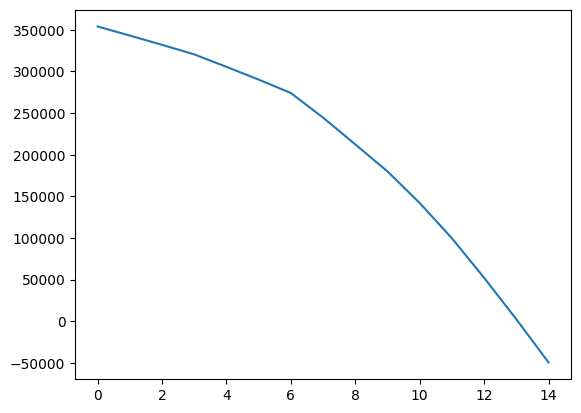

In [93]:
plt.plot(value)

### Doing it for all the loans

In [131]:
newdf = pd.DataFrame(index = df.index)
col = 0
for i in df.iloc[:, 0:8].columns:
    newdf[df.columns[col]] = 0
    col += 1

In [136]:
#iterate through the columns
col = 0
for i in df.iloc[:, 0:8].columns:
    #iterate through the rows
    row = 0
    for j in df.index:
        loan = df.iloc[row, col]
        #print("-----------------------------------")
        #print("city:", df.columns[col])
        #print("loan starting amount:", loan)
        quarter = 0
        while loan > 0 and quarter < len(df):
            loan = loan*(1+df.iloc[quarter, 9]) - df.iloc[quarter, 10+col]
            quarter += 4
            yearsleft = 0
        if loan > 0:
            try:
                yearsleft = math.log(1/-((loan*df['Mortgage Rate'][-1]/df.iloc[-1][col+10])-1)) / math.log(1+df['Mortgage Rate'][-1])
            except ValueError as e:
                    yearsleft = np.nan
        #print("loan started at:", row, ", years with loan:", (quarter-row)/4)
        #print("loan amount at end:", loan)
        #print("years left:", yearsleft)
        #print("total years:", (quarter-row)/4 + yearsleft)
        totalYears = (quarter-row)/4 + yearsleft
        newdf.iloc[row,col] = totalYears
        quarter = 0
        row += 1
    col += 1

# Visualisation

In [139]:
years = np.arange(2002.25, 2023.75 + 0.25, 0.25)

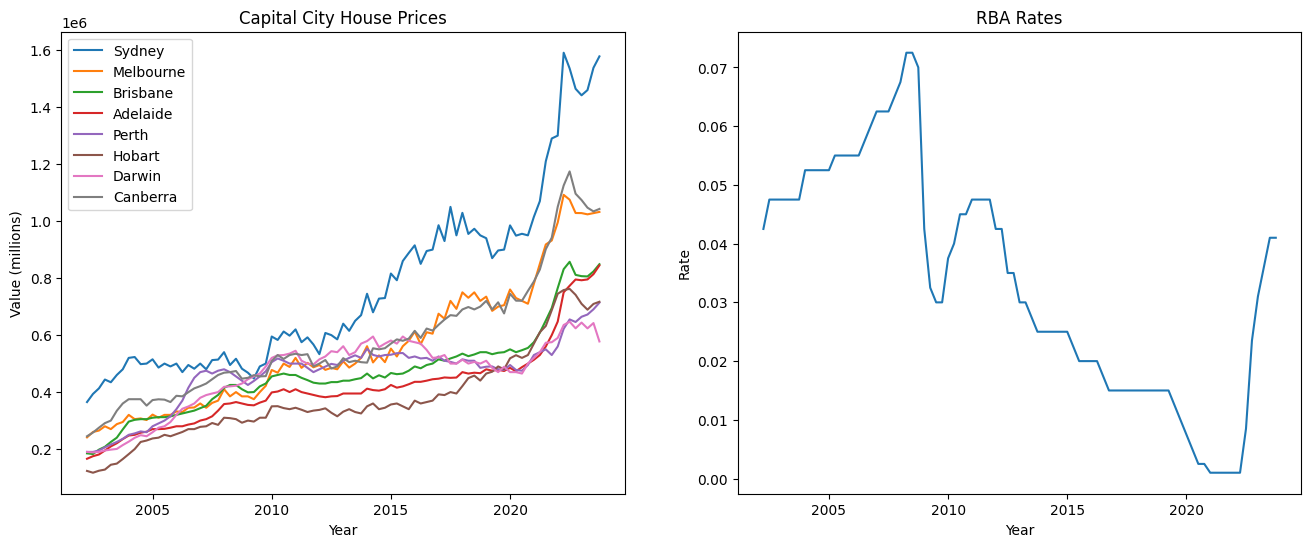

In [29]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
for column in df.iloc[0:,0:8].columns:
    ax = sns.lineplot(y=df.iloc[0:,0:8][column], x=years, label=column)
plt.xlabel('Year')
plt.ylabel('Value (millions)')
plt.title('Capital City House Prices')
plt.subplot(1,2,2)
plt.xlabel('Year')
plt.ylabel('Rate')
plt.title('RBA Rates')
ax = sns.lineplot(y=df['RBA Rate'], x=years)
plt.show()

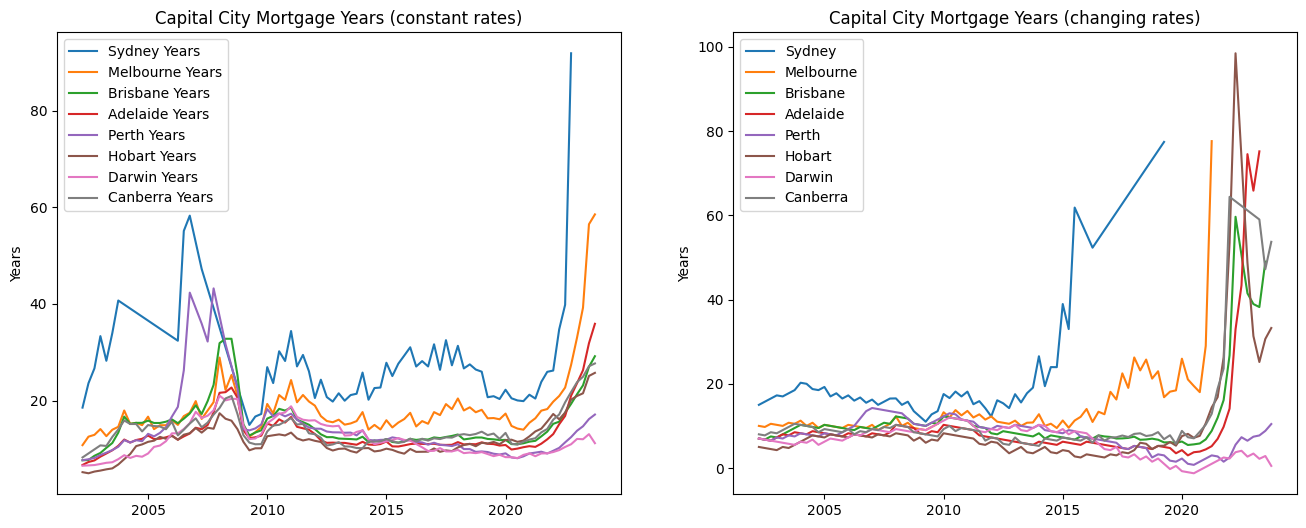

In [158]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
for column in df.iloc[0:,18:26].columns:
    ax = sns.lineplot(y=df.iloc[:, 18:26][column], x=years, label=column, linestyle='-', marker='')
    ax.set_ylabel("Years")
    plt.title('Capital City Mortgage Years (constant rates)')
plt.subplot(1,2,2)
for column in newdf.columns:
    ax = sns.lineplot(y=newdf[column], x=years, label=column, linestyle='-', marker='')
    ax.set_ylabel("Years")
    plt.title('Capital City Mortgage Years (changing rates)')

Each quarter's datapoint represents a new home loan being sold and the number of years to pay it off. 

On the left we are assuming the whole median income (state/territory) is used yearly and stays the same. Similarly, we are using the median house prices (capital city) from the time that the loan was taken out. Because it is capital city prices with region wide wages it's likely that Canberra is the only accurate depiction of expectations at the time it was taken out. We are assuming a fixed interest rate at rba + 2% on loans. 

On the right we are modelling what actually occurred had the debtors repaid their loans using the variable rba + 2% interest rate. This time we are also using the variable median yearly wages to repay the loan each year. In the circumstances where the loan is not repaid upto september of 2023 we take the rest of the loan and figure out the number of years left on the loan if rates and wages stay constant. 

In [144]:
newdf

,Sydney,Melbourne,Brisbane,Adelaide,Perth,Hobart,Darwin,Canberra
Date,,,,,,,,
2002-01-03,15.00,10.00,7.000000,7.000000,7.000000,5.000000,7.000000,8.000000
2002-01-06,15.75,9.75,6.750000,6.750000,6.750000,4.750000,6.750000,7.750000
2002-01-09,16.50,10.50,7.500000,6.500000,6.500000,4.500000,6.500000,8.500000
2002-01-12,17.25,10.25,7.250000,7.250000,7.250000,4.250000,6.250000,8.250000
2003-01-03,17.00,10.00,8.000000,8.000000,7.000000,5.000000,6.000000,9.000000
...,...,...,...,...,...,...,...,...
2022-01-09,NaN,NaN,41.489562,74.533714,6.482674,48.768655,2.700093,NaN
2022-01-12,NaN,NaN,38.937739,65.868992,7.438559,31.336934,3.432316,NaN
2023-01-03,NaN,NaN,38.226509,75.196900,7.732041,25.174230,2.189632,59.019676


Text(0.5, 1.0, 'Canberra Mortgage Years')

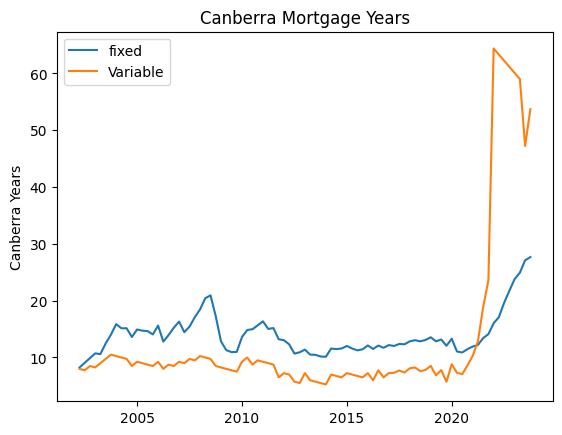

In [157]:
ax.set_ylabel("Years")
ax = sns.lineplot(y=df['Canberra Years'], x=years, label='fixed', linestyle='-', marker='')
ax = sns.lineplot(y=newdf['Canberra'], x=years, label='Variable', linestyle='-', marker='')
plt.title('Canberra Mortgage Years')